**Introducing BESS**

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [35]:
plt.rcParams["figure.figsize"] = (15,8) #set size of plot
plt.rcParams.update({'font.size': 22})

In [36]:
os.chdir('/home/MA')

In [37]:
power_balance = pd.read_pickle('Calculations/Norway/power_balance_Norway.pkl')

Define battery size

In [38]:
battery_size = 72

In [39]:
max_c_charge = 0.25
max_c_discharge = 0.5

Roundtrip efficiency solar battery: 85% (check alternative sources) https://www.homerenergy.com/products/pro/docs/latest/battery_roundtrip_efficiency.html#:~:text=The%20battery%20round%2Dtrip%20efficiency,Typically%20it%20is%20about%2080%25.
Assumption: Losses occur during discharging only (Charging efficiency is 99% https://www.powertechsystems.eu/home/tech-corner/lithium-ion-battery-advantages/)

In [40]:
eta_discharge = 0.85

Define function for battery dispatch

In [41]:
from Battery_dispatch_function import BatteryDispatch

In [42]:
power_balance = BatteryDispatch(power_balance, battery_size, eta_discharge, max_c_charge, max_c_discharge)

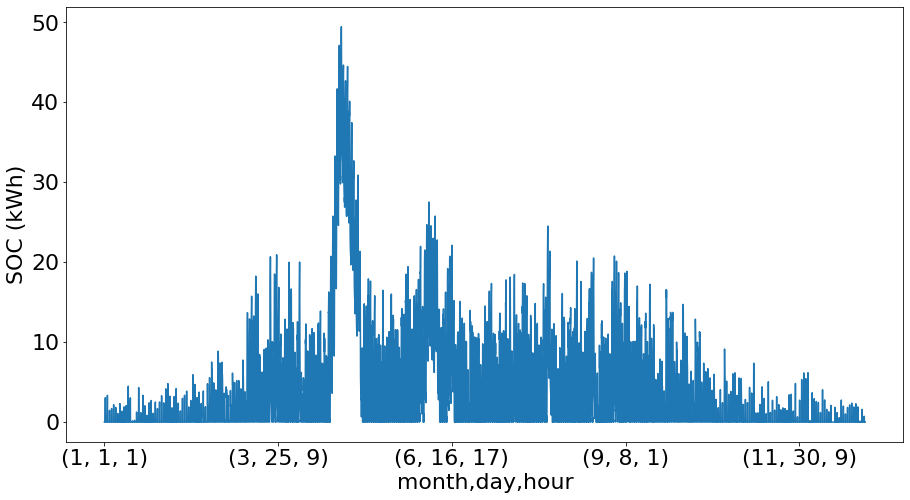

In [43]:
power_balance['SoC'].plot(ylabel = 'SOC (kWh)'); 

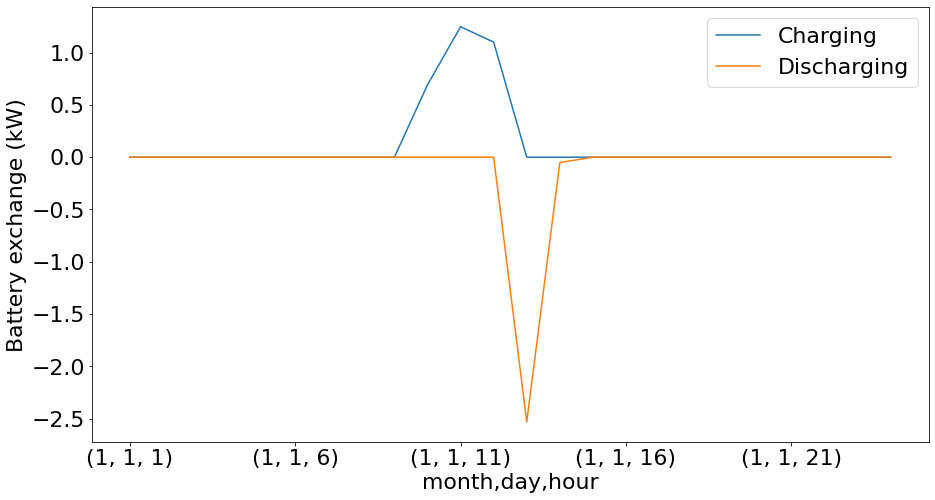

In [44]:
power_balance[['Charging', 'Discharging']].head(24).plot(ylabel = 'Battery exchange (kW)'); 

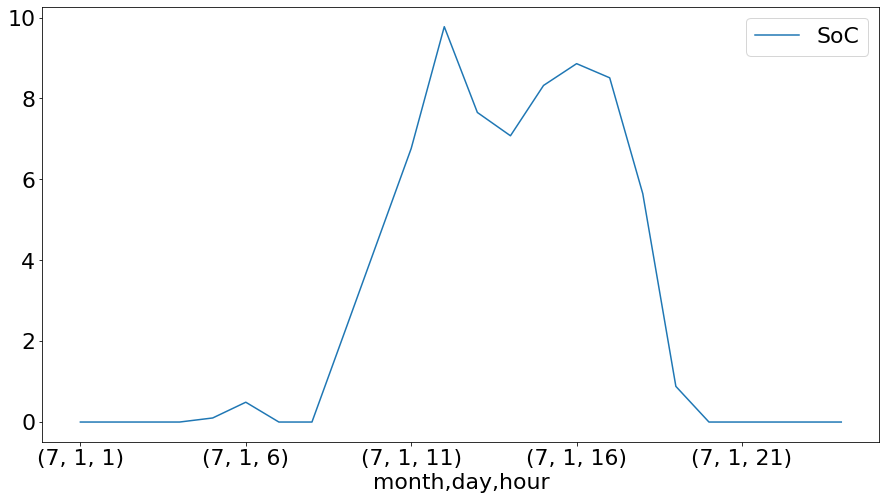

In [45]:
power_balance[['SoC']].iloc[power_balance.index.get_level_values('month') == 7].head(24).plot();

In [46]:
sum(power_balance['Charging'])

3639.2232818521334

In [47]:
sum(power_balance['Discharging'])

-3093.3397895743174

Check how many cycles were carried out

In [48]:
sum(power_balance['Charging'])/battery_size

50.544767803501855

In [49]:
power_balance['exchange grid new'] = power_balance['to Grid New'] - power_balance['from Grid New']

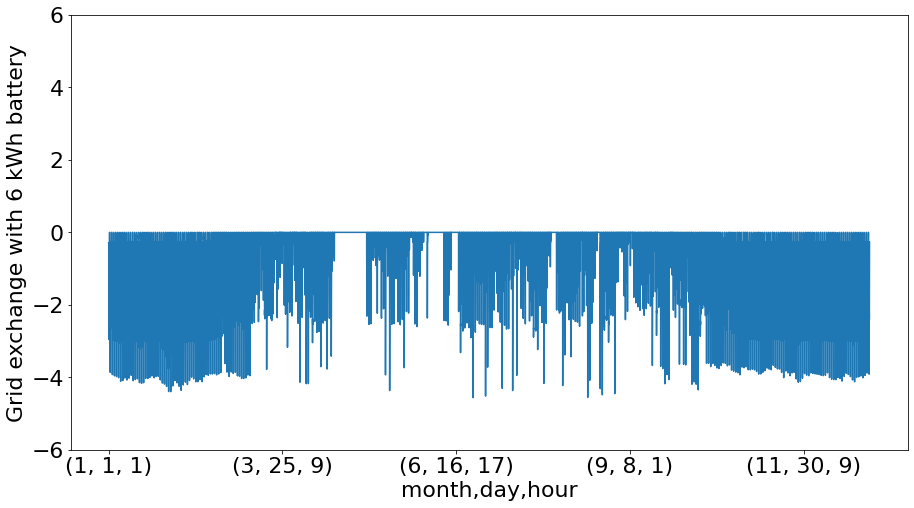

In [50]:
power_balance['exchange grid new'].plot(ylabel = 'Grid exchange with 6 kWh battery', ylim = ([-6, 6]));

Self-consumption share with BESS

In [51]:
sum(power_balance['consumption'] - power_balance['from Grid New'])/sum(power_balance['from PV'])

0.9189512166212973

Curtailment calculation with BESS

In [52]:
sum(power_balance['to Grid New'])/sum(power_balance['from PV'])

The history saving thread hit an unexpected error (OperationalError('database is locked',)).History will not be written to the database.


0.0

PV share with BESS

In [53]:
1-sum(power_balance['from Grid New'])/sum(power_balance['consumption'])

0.5399565217461079

Losses in the battery system

In [54]:
(sum(power_balance['Charging']) + sum(power_balance['Discharging']))/sum(power_balance['from PV'])

0.08104878337870046

Reduced consumption from grid:
also mention PV reduction, check with curtailment!

In [55]:
grid_savings = sum(power_balance['Discharging'])
grid_savings

-3093.3397895743174

**CO$_2$ calculations**

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [57]:
plt.rcParams["figure.figsize"] = (15,8) #set size of plot

In [58]:
os.chdir('/home/MA')

In [59]:
PV_lifetime = 25 #years

In [60]:
power_balance = pd.read_pickle('Calculations/Norway/power_balance_Norway.pkl')

Emissions of grid mix at consumer level are taken from https://www.bafu.admin.ch/bafu/de/home/themen/klima/klimawandel--fragen-und-antworten.html#:~:text=Die%20Kennzahlen%20f%C3%BCr%20die%20verschiedenen,)%20(relevant%20f%C3%BCr%20volkswirtschaftliche%20Betrachtungen)

In [61]:
battery_lifetime = 15 # years

Electricity mix carbon intensity for Norway

https://www.nve.no/norwegian-energy-regulatory-authority/retail-market/electricity-disclosure-2018/

In [62]:
grid_emissions_Norway= 18.9 # g CO2/kWh

Battery production energy intensity from https://www.researchgate.net/publication/331837767_The_energetic_implications_of_introducing_lithium-ion_batteries_into_distributed_photovoltaic_systems

In [63]:
elec_battery_prod = 95.5 # kwh_el/kWh_n

Assumption: Battery production in China
at 637 g CO2/kWh
https://www.mdpi.com/1996-1073/14/4/961/pdf

In [64]:
CO2_intensity_China = 637

In [65]:
electricity_PV_production = 1597 # kWh_el kWp-1

In [66]:
PV_size = 6 #kW_p

### CO2 savings of PV only

Yearly energy self consumed, therefore reduced consumption from grid

In [67]:
self_consumption_kWh = sum(power_balance['consumption'] - power_balance['from Grid'])

In [68]:
total_CO2_PV_prod = electricity_PV_production * PV_size * CO2_intensity_China

In [69]:
reduced_CO2_PV_g = grid_emissions_Norway * self_consumption_kWh * PV_lifetime - total_CO2_PV_prod

In [70]:
reduced_CO2_PV_t = reduced_CO2_PV_g/1000000

In [71]:
reduced_CO2_PV_t

-4.640863276043133

### CO2 savings of added batteries

In [72]:
battery_size = [0, 6, 12, 18, 24, 72]
results = pd.DataFrame()
results['battery_size'] = battery_size
results['curtailment'] = ''
results['yearly_savings_kWh'] = ''

In [73]:
for i in range(0, len(results['battery_size'])):
    powerbalance = BatteryDispatch(power_balance, results['battery_size'].values[i], eta_discharge, max_c_charge, max_c_discharge)
    results['yearly_savings_kWh'].values[i] = -sum(power_balance['Discharging'])
    results['curtailment'].values[i] = sum(power_balance['to Grid New'])/sum(power_balance['from PV'])

In [74]:
results['total_savings_kWh'] = results['yearly_savings_kWh'] * PV_lifetime

The yearly CO2 savings by grid consumption reduction in tons amount to:

In [75]:
results['yearly_savings_CO2'] = results['yearly_savings_kWh'] * grid_emissions_Norway / 1000000

For a PV lifetime of 25 years, this corresponds to a gross saving of 

In [76]:
results['total_CO2_grid_reduced'] = results['yearly_savings_CO2'] * PV_lifetime

Caclculate total battery energy intensity by accounting for dead capacity (20%) which is not used when cycling to improve performance, and for a replacement after 15 years (battery lifetime)

In [77]:
results['total_elec_battery_prod'] = 2 * (elec_battery_prod * results['battery_size']/0.8)

Net saving of battery deployment

In [78]:
results['total_CO2_battery_prod'] = results['total_elec_battery_prod'] * CO2_intensity_China / 1000000

In [79]:
results['net_CO2_savings'] = results['total_CO2_grid_reduced'] - results['total_CO2_battery_prod'] 

In [80]:
results['stored'] = results.iloc[0]['curtailment'] - results['curtailment']

In [81]:
results

,battery_size,curtailment,yearly_savings_kWh,total_savings_kWh,yearly_savings_CO2,total_CO2_grid_reduced,total_elec_battery_prod,total_CO2_battery_prod,net_CO2_savings,stored
0,0,0.540325,-0,-0,-0,-0,0.0,0.000000,-0,0
1,6,0.244819,1691.76,42294.1,0.0319743,0.799358,1432.5,0.912502,-0.113145,0.295506
2,12,0.079629,2637.47,65936.7,0.0498481,1.2462,2865.0,1.825005,-0.578802,0.460696
3,18,0.0128794,3019.61,75490.1,0.0570705,1.42676,4297.5,2.737507,-1.31074,0.527446
4,24,0.00437458,3068.3,76707.4,0.0579908,1.44977,5730.0,3.650010,-2.20024,0.535951
5,72,0,3093.34,77333.5,0.0584641,1.4616,17190.0,10.950030,-9.48843,0.540325


In [82]:
results.set_index("battery_size",drop=True,inplace=True)

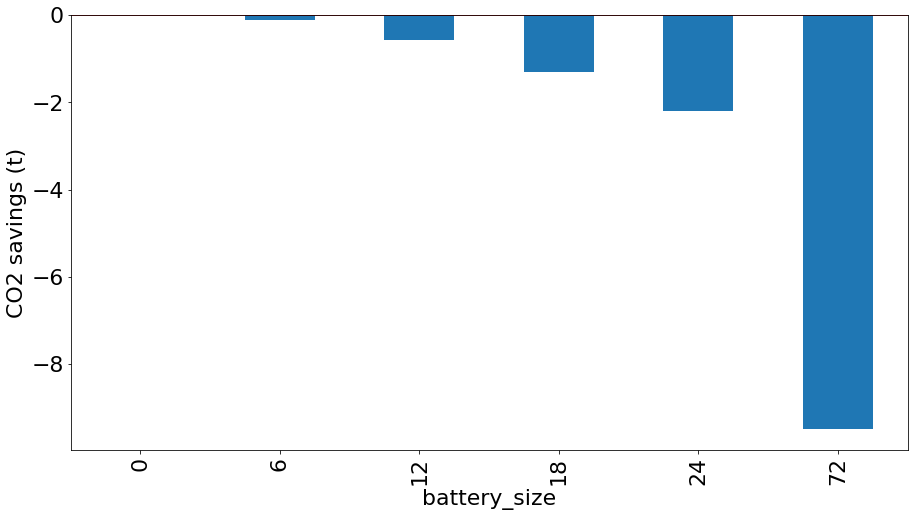

In [83]:
results['net_CO2_savings'].plot.bar(ylabel ='CO2 savings (t)');
plt.axhline(y=0, color='r', linestyle='-')

In [84]:
results['net_CO2_savings_with_PV'] = results['net_CO2_savings'] + reduced_CO2_PV_t

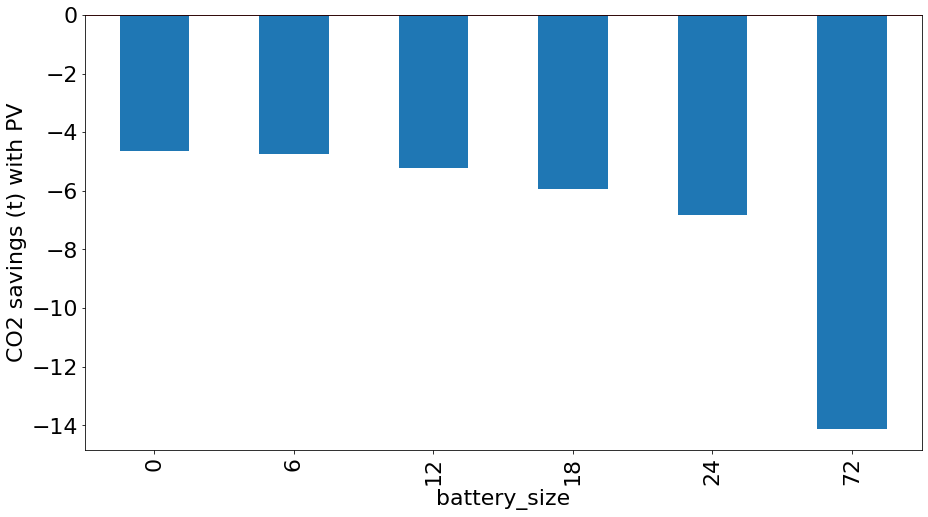

In [85]:
results['net_CO2_savings_with_PV'].plot.bar(ylabel ='CO2 savings (t) with PV');
plt.axhline(y=0, color='r', linestyle='-')

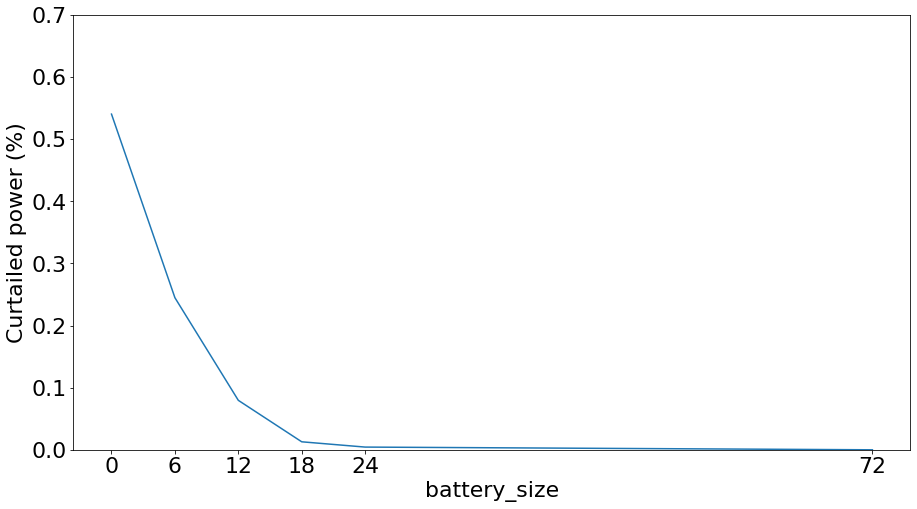

In [86]:
results['curtailment'].plot(xticks = battery_size, ylabel = 'Curtailed power (%)', ylim = ([0, 0.7]));

## EROI calculations

Electricity intensity used for PV production

In [87]:
PV_production_hourly = pd.read_pickle('Calculations/Norway/PV_production_Norway.pkl')

In [88]:
yearly_PV_production = sum(PV_production_hourly)

In [89]:
results['total_elec_PV_prod'] = electricity_PV_production * PV_size

In [90]:
results['ESOI'] = results['total_savings_kWh'].div(results['total_elec_battery_prod'].where(results['total_elec_battery_prod'] != 0, np.nan))

In [91]:
results['EROI_gen'] = yearly_PV_production*PV_lifetime/results['total_elec_PV_prod']

**Firstly, calculate the EROI for the case where electricity can be made usful through the distribution grid:**

In [92]:
results['EROI_grid_useful'] = results['EROI_gen']

**Now, let's consider the case where power is curtailed unless stored for later use**

In [93]:
results['EROI_grid_curtailed'] = (1 - results['stored'] + eta_discharge * results['stored'])/(1/results['EROI_gen']+results['stored']/results['ESOI'])*(1-results['curtailment'])

In [94]:
results['EROI_grid_curtailed'] = results['EROI_grid_curtailed'].fillna(results['EROI_gen']*(1-results['curtailment']))

In [95]:
results['ESOI'] = results['ESOI'].fillna(0)

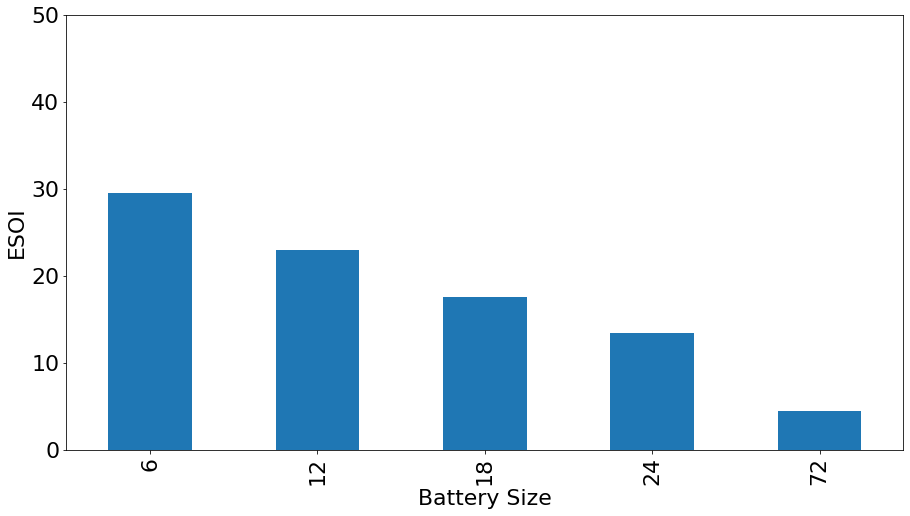

In [96]:
results.ESOI[results['ESOI']!=0].plot.bar(xlabel = 'Battery Size', ylabel = 'ESOI', ylim = ([0, 50]));

In [97]:
results

,curtailment,yearly_savings_kWh,total_savings_kWh,yearly_savings_CO2,total_CO2_grid_reduced,total_elec_battery_prod,total_CO2_battery_prod,net_CO2_savings,stored,net_CO2_savings_with_PV,total_elec_PV_prod,ESOI,EROI_gen,EROI_grid_useful,EROI_grid_curtailed
battery_size,,,,,,,,,,,,,,,
0,0.540325,-0,-0,-0,-0,0.0,0.000000,-0,0,-4.64086,9582,0.000000,17.572652,17.572652,8.077705
6,0.244819,1691.76,42294.1,0.0319743,0.799358,1432.5,0.912502,-0.113145,0.295506,-4.75401,9582,29.524646,17.572652,17.572652,10.785364
12,0.079629,2637.47,65936.7,0.0498481,1.2462,2865.0,1.825005,-0.578802,0.460696,-5.21967,9582,23.014545,17.572652,17.572652,11.137835
18,0.0128794,3019.61,75490.1,0.0570705,1.42676,4297.5,2.737507,-1.31074,0.527446,-5.95161,9582,17.566060,17.572652,17.572652,10.456587
24,0.00437458,3068.3,76707.4,0.0579908,1.44977,5730.0,3.650010,-2.20024,0.535951,-6.8411,9582,13.386979,17.572652,17.572652,9.444680
72,0,3093.34,77333.5,0.0584641,1.4616,17190.0,10.950030,-9.48843,0.540325,-14.1293,9582,4.498749,17.572652,17.572652,5.191455


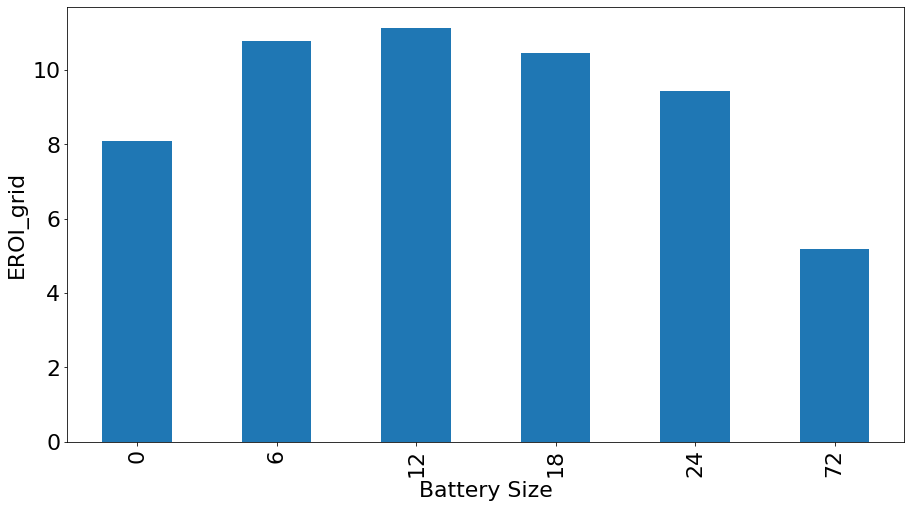

In [98]:
results['EROI_grid_curtailed'].plot.bar(xlabel = 'Battery Size', ylabel = 'EROI_grid');